<a href="https://colab.research.google.com/github/mritunjay29-ai/Namekart-Domain-Name-Evaluation/blob/main/Model_Namekart_Unsuccessful.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import DistilBertModel

In [2]:
df = pd.read_csv("/content/sample_data/data.csv")

In [3]:
price_features = ['bidders', 'sld_length', 'encoded_category']
bid_features = ['price']

target_price = 'price'
target_bid = 'bid_amount'

X_price = df[price_features].values
X_bid = df[bid_features].values
y_price = df[target_price].values
y_bid = df[target_bid].values

X_price_train, X_price_test, X_bid_train, X_bid_test, y_price_train, y_price_test, y_bid_train, y_bid_test = train_test_split(
    X_price, X_bid, y_price, y_bid, test_size=0.2, random_state=42
)

scaler_price = StandardScaler()
scaler_bid = StandardScaler()

X_price_train = scaler_price.fit_transform(X_price_train)
X_price_test = scaler_price.transform(X_price_test)
X_bid_train = scaler_bid.fit_transform(X_bid_train)
X_bid_test = scaler_bid.transform(X_bid_test)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
X_price_train = torch.tensor(X_price_train, dtype=torch.float32).to(device)
X_price_test = torch.tensor(X_price_test, dtype=torch.float32).to(device)
X_bid_train = torch.tensor(X_bid_train, dtype=torch.float32).to(device)
X_bid_test = torch.tensor(X_bid_test, dtype=torch.float32).to(device)
y_price_train = torch.tensor(y_price_train, dtype=torch.float32).view(-1, 1).to(device)
y_price_test = torch.tensor(y_price_test, dtype=torch.float32).view(-1, 1).to(device)
y_bid_train = torch.tensor(y_bid_train, dtype=torch.float32).view(-1, 1).to(device)
y_bid_test = torch.tensor(y_bid_test, dtype=torch.float32).view(-1, 1).to(device)

batch_size = 32
train_dataset = TensorDataset(X_price_train, X_bid_train, y_price_train, y_bid_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
class DistilBERTMultiTaskModel(nn.Module):
    def __init__(self, price_dim, bid_dim):
        super(DistilBERTMultiTaskModel, self).__init__()

        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        self.price_fc = nn.Linear(price_dim, 768)
        self.bid_fc = nn.Linear(bid_dim, 768)

        self.price_out = nn.Linear(768, 1)
        self.bid_out = nn.Linear(768, 1)

    def forward(self, x_price, x_bid):
        x_price_embed = self.price_fc(x_price)
        x_bid_embed = self.bid_fc(x_bid)

        x_price_bert = self.bert(inputs_embeds=x_price_embed.unsqueeze(1)).last_hidden_state[:, 0, :]
        x_bid_bert = self.bert(inputs_embeds=x_bid_embed.unsqueeze(1)).last_hidden_state[:, 0, :]

        price_output = self.price_out(x_price_bert)
        bid_output = self.bid_out(x_bid_bert)

        return price_output, bid_output


In [7]:
input_price_dim = X_price_train.shape[1]
input_bid_dim = X_bid_train.shape[1]
model = DistilBERTMultiTaskModel(input_price_dim, input_bid_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 100
losses = []

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [8]:
def train_model(model, train_loader, optimizer, criterion, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_price_batch, X_bid_batch, y_price_batch, y_bid_batch in train_loader:
            optimizer.zero_grad()
            price_pred, bid_pred = model(X_price_batch, X_bid_batch)
            loss_price = criterion(price_pred, y_price_batch)
            loss_bid = criterion(bid_pred, y_bid_batch)
            total_loss = loss_price + loss_bid
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        losses.append(epoch_loss / len(train_loader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

    print("Training Complete")

In [ ]:
train_model(model, train_loader, optimizer, criterion, num_epochs)

Epoch 0, Loss: 2964933.117419325
Epoch 5, Loss: 2795735.4873008747
Epoch 10, Loss: 2802723.729740942
Epoch 15, Loss: 2802701.250273309
Epoch 20, Loss: 2788624.380270967
Epoch 25, Loss: 2802683.2926118616


In [ ]:
def evaluate_and_plot(model, X_price_test, X_bid_test, y_price_test, y_bid_test):
    model.eval()
    with torch.no_grad():
        price_pred, bid_pred = model(X_price_test, X_bid_test)

    plt.figure(figsize=(10, 5))
    plt.plot(y_price_test.cpu().numpy(), label='Actual Price', color='blue')
    plt.plot(price_pred.cpu().numpy(), label='Predicted Price', color='red', linestyle='dashed')
    plt.legend()
    plt.title('Actual vs Predicted Price')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(y_bid_test.cpu().numpy(), label='Actual Bid Amount', color='blue')
    plt.plot(bid_pred.cpu().numpy(), label='Predicted Bid Amount', color='red', linestyle='dashed')
    plt.legend()
    plt.title('Actual vs Predicted Bid Amount')
    plt.show()

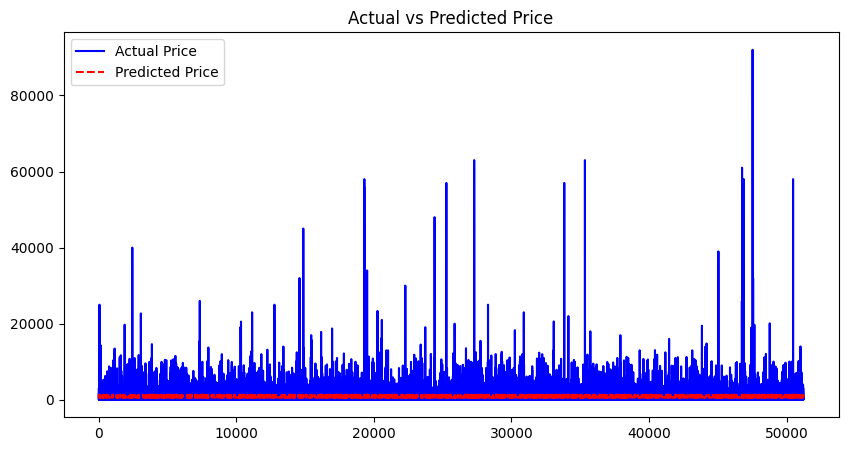

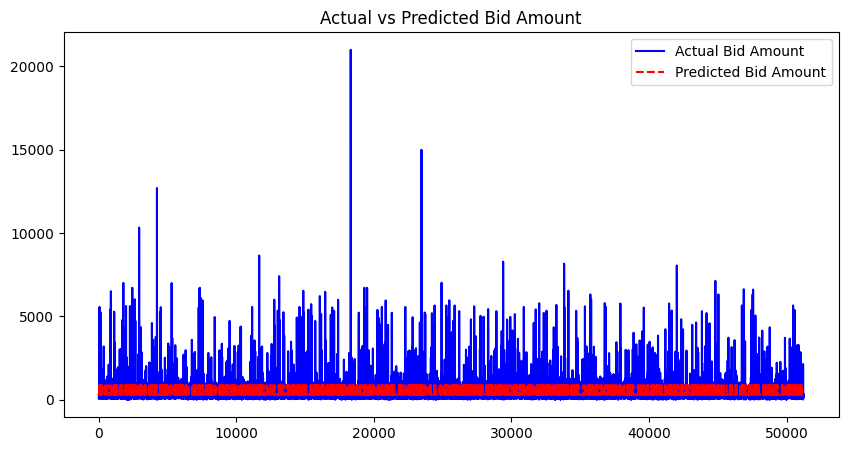

In [ ]:
evaluate_and_plot(model, X_price_test, X_bid_test, y_price_test, y_bid_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score

def evaluate_metrics(y_true, y_pred, task_name):
    y_true = y_true.cpu().numpy().flatten()
    y_pred = y_pred.cpu().numpy().flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Metrics for {task_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")

    y_true_class = (y_true > np.median(y_true)).astype(int)  # Convert to binary
    y_pred_class = (y_pred > np.median(y_true)).astype(int)

    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, zero_division=0)
    recall = recall_score(y_true_class, y_pred_class, zero_division=0)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("\n")


In [ ]:
model.eval()
with torch.no_grad():
    price_pred, bid_pred = model(X_price_test, X_bid_test)

print("Evaluating Model Performance...")
evaluate_metrics(y_price_test, price_pred, "Price Prediction")
evaluate_metrics(y_bid_test, bid_pred, "Bid Amount Prediction")

Evaluating Model Performance...
Metrics for Price Prediction:
  RMSE: 1630.7190
  MAE: 787.3549
  R² Score: 0.0194
  Accuracy: 0.4969
  Precision: 0.4969
  Recall: 1.0000


Metrics for Bid Amount Prediction:
  RMSE: 391.6372
  MAE: 158.9562
  R² Score: 0.0809
  Accuracy: 0.5000
  Precision: 0.5000
  Recall: 1.0000


